In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import geopandas as gpd
from pypalettes import load_cmap

In [2]:
REG_SEC_list = pd.read_excel("D:/Poweroutage_Cascades/WP2_ARIO_EconLoss/data/REG_SEC_list.xlsx", sheet_name="REG_SEC").squeeze().tolist()
IOX_TIM = pd.read_csv("D:/Poweroutage_Cascades/WP2_ARIO_EconLoss/results/ARIO_loss_future_2023-2027_NUTS2-sectors_millionEUR.csv")

# set Date as index
IOX_TIM.set_index('Date', inplace=True)


In [ ]:
# 定义函数将月份转换为季度
def month_to_season(m):
    if m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    elif m in [9, 10, 11]:
        return "autumn"
    else:
        return "winter"

# 创建季度索引
seasons = pd.to_datetime(IOX_TIM.index).to_series().dt.month.map(month_to_season)

# 创建多重索引
IOX_TIM.index = pd.MultiIndex.from_arrays([IOX_TIM.index, seasons], names=["Date", "Season"])

# 创建年份索引
years = pd.to_datetime(IOX_TIM.index.get_level_values('Date')).year

# 将年份添加为新的索引
IOX_TIM.index = pd.MultiIndex.from_arrays([IOX_TIM.index.get_level_values('Date'), IOX_TIM.index.get_level_values('Season'), years], names=["Date", "Season", "Year"])

IOX_TIM.columns = REG_SEC_list

# 获取初始输出（为第一行数据）
IOX_0 = IOX_TIM.iloc[0]

power_sec = "D35"

# 计算经济损失
IOX_TIM_Econ_Loss = IOX_0 - IOX_TIM


In [70]:
# 计算分区域电力部门损失
IOX_TIM_Powersector_Econ_Loss = IOX_TIM_Econ_Loss.loc[:, IOX_TIM_Econ_Loss.columns.str.contains(power_sec)]
# 计算分区域总损失
IOX_TIM_Reg_Econ_Loss = IOX_TIM_Econ_Loss.T.groupby(lambda col: col.split('_')[0]).sum().T #  REG_C为区域总损失
IOX_TIM_Reg_0 = IOX_TIM.T.groupby(lambda col: col.split('_')[0]).sum().T.iloc[0] # 初始输出

# 计算电力部门损失占总损失比重 Direct loss/total loss

Direct_loss_ratio = IOX_TIM_Powersector_Econ_Loss.sum(axis=0).values \
                    / IOX_TIM_Reg_Econ_Loss.sum(axis=0).values

Direct_loss_ratio = pd.DataFrame(Direct_loss_ratio.reshape(1, -1), columns=IOX_TIM_Reg_Econ_Loss.columns)
print(Direct_loss_ratio)

       UKC1      UKC2      UKD1      UKD3      UKD4      UKD6      UKD7  \
0  0.376236  0.285103  0.077909  0.292862  0.047847  0.499634  0.019591   

       UKE1      UKE2      UKE3  ...      UKK2      UKK3      UKK4      UKL1  \
0  0.300098  0.298822  0.133681  ...  0.115306  0.061513  0.143324  0.091632   

       UKL2      UKM2      UKM3      UKM5      UKM6      UKN0  
0  0.414555  0.269703  0.356733  0.121855  0.127108  0.042849  

[1 rows x 37 columns]


In [ ]:
# 计算经济损失比例 Economic loss ratio = (Initial output - Output after outage) / Initial output
IOX_TIM_Reg_Eco_Loss_ratio =  IOX_TIM_Reg_Econ_Loss / IOX_TIM_Reg_0 * 100

# 计算年均损失
Annual_Reg_Eco_Loss_ratio = IOX_TIM_Reg_Eco_Loss_ratio.groupby(level="Year").mean()

# 计算年均损失的均值、中位数、四分位数
Annual_Reg_Eco_forplot = pd.DataFrame(
    [Annual_Reg_Eco_Loss_ratio.mean(), 
    #  Annual_Reg_Eco_Loss_ratio.median(),
     Annual_Reg_Eco_Loss_ratio.quantile(0.75), 
     Annual_Reg_Eco_Loss_ratio.quantile(0.25)],
    index=["mean", "q75", "q25"]
)

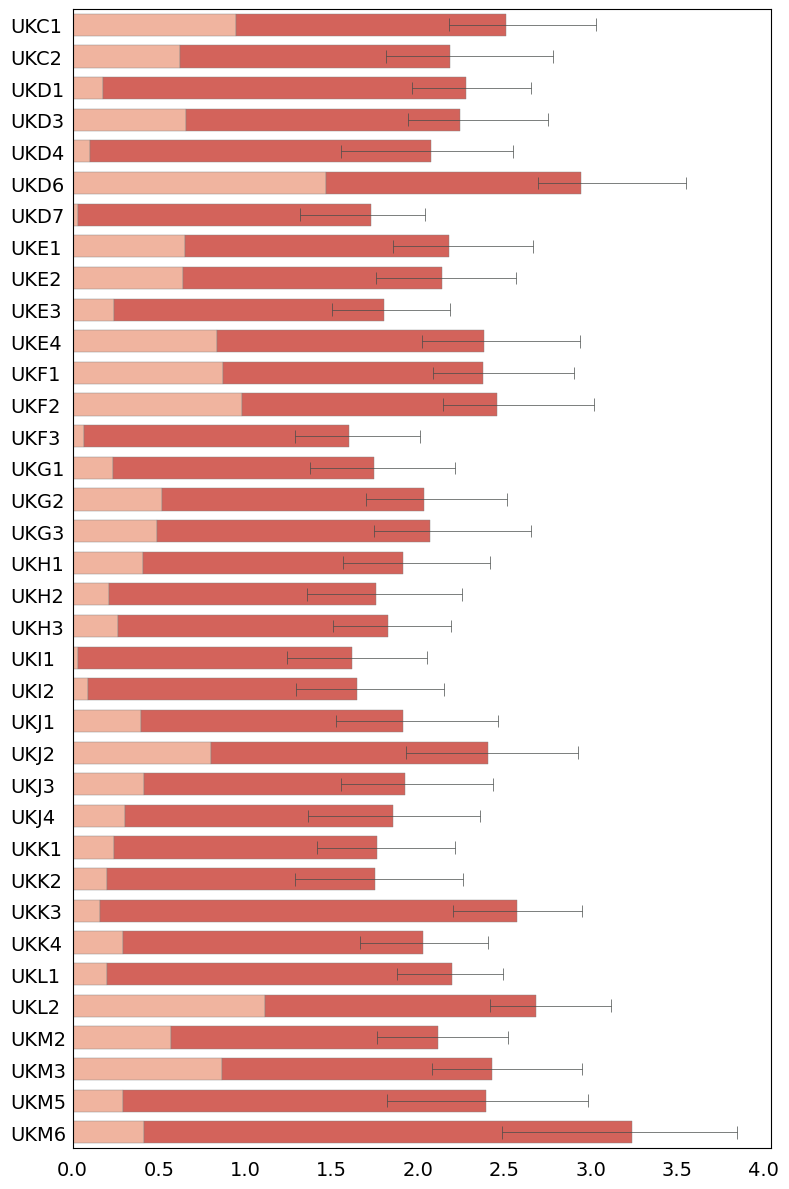

In [81]:
"""Figure S2. """

regions = Annual_Reg_Eco_forplot.columns.tolist()
regions.remove("UKN0")

# Create a color palette
# colors = load_cmap("Alosa_fallax").colors
colors = ["#FAEDCD","#F0B49F","#DF827D","#D3635B"]  # spring, summer, autumn, winter

# Create the figure
fig, ax = plt.subplots(figsize=(8, 12))

y = np.arange(len(regions))  # the label locations

for i, region in enumerate(regions):
    
    Mean_Loss = Annual_Reg_Eco_forplot.loc["mean", region]  # 平均总损失
    Ratio_Power = Direct_loss_ratio.loc[0, region]           # 电力损失占比
    Dir_Loss = Mean_Loss * Ratio_Power                     # 电力损失量
    Indir_Loss = Mean_Loss * (1 - Ratio_Power)               # 非电力损失量

    # 电力损失部分（左侧）
    ax.barh(
        y[i],
        Dir_Loss,
        left=0,
        color=colors[1],  # 红色代表电力
        edgecolor='grey',
        linewidth=0.3,
        label="Power" if i == 0 else "",
        height=0.7
    )

        # 非电力损失部分（右侧）
    ax.barh(
        y[i],
        Indir_Loss,
        left=Dir_Loss,
        color=colors[3],  # 蓝绿色代表非电力
        edgecolor='grey',
        linewidth=0.3,
        label="Non-Power" if i == 0 else "",
        height=0.7
    )

    # Add error bars for min and max
    # 画出四分位范围误差线
    q25 = Annual_Reg_Eco_forplot.loc["q25", region]
    q75 = Annual_Reg_Eco_forplot.loc["q75", region]

    ax.hlines(
        y[i], 
        q25, 
        q75, 
        color="#464B49", 
        linestyle='-', 
        linewidth=0.5
    )

    ax.vlines(
        [q25, q75],
        y[i] - 0.2,
        y[i] + 0.2,
        color="#464B49",
        # linestyle='--',
        linewidth=0.5
    )

ax.set_yticks(y)
ax.set_yticklabels(regions, ha='left')     # 设置 label 左对齐
ax.tick_params(axis='y', pad=40)           # 调整标签与轴之间的距离
ax.set_ylim(-0.5, len(regions)-0.5)
ax.tick_params(axis='both', which='major', labelsize=14, length=5, colors='white', labelcolor='black')

ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Average Annual GDP Loss (%)')
# ax.set_xlim(0, 1.2 * range_q75.max())

# ax.legend(title="Season", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
# # 按 年 × 季度 分组，计算季度总损失
# Regional_loss =  IOX_REG_C_0 - IOX_REG_C
# # Regional_loss_by_season = Regional_loss.groupby(level='Season').sum()
# Regional_loss_by_season = Regional_loss.groupby(level=["Year", "Season"]).sum()

# # 1. 计算每年的天数
# days_in_each_year = Regional_loss.groupby(level="Year").size()

# # 2. 年均百分比损失
# annual_loss_total = Regional_loss_by_season.groupby(level="Year").sum()
# annual_loss_total_normalized = annual_loss_total.div(days_in_each_year, axis=0)

# # 3. 每年季度损失百分比 
# seasonal_loss_normalized = Regional_loss_by_season.div(
#     days_in_each_year.reindex(Regional_loss_by_season.index.get_level_values("Year")).values,
#     axis=0 # 使用reindex把Regional_loss_by_season.index的Year和days_in_each_year进行匹配
# )

# # 4. 每年季度损失占比（相对当年总损失）
# seasonal_share_by_year = seasonal_loss_normalized.div(annual_loss_total_normalized, level="Year")

# # 5. 所有年份季度占比的平均值
# mean_seasonal_share = seasonal_share_by_year.groupby(level="Season").mean()

# # 6. 平均年度总损失
# mean_annual_loss = annual_loss_total_normalized.mean()

# # 7. 最终结果1：平均年度季度损失（占基准GDP百分比）
# avg_annual_seasonal_loss = mean_seasonal_share * mean_annual_loss / IOX_REG_C_0 * 100
# season_order = ["spring", "summer", "autumn", "winter"]
# avg_annual_seasonal_loss = avg_annual_seasonal_loss.loc[season_order]

# # 8. 所有年份的年度总损失（百分比）
# annual_loss_percent = annual_loss_total_normalized / IOX_REG_C_0 * 100

# # 9. 最终结果2：每个区域的最大值和最小值（跨所有年份）
# yearly_extremes = pd.DataFrame(
#     [annual_loss_percent.quantile(0.75), annual_loss_percent.quantile(0.25)],
#     index=["q75", "q25"]
# )


In [175]:
REG_SEC_list_fullname = pd.read_excel("D:/Poweroutage_Cascades/WP2_ARIO_EconLoss/data/REG_SEC_list.xlsx", sheet_name="NUTS2")

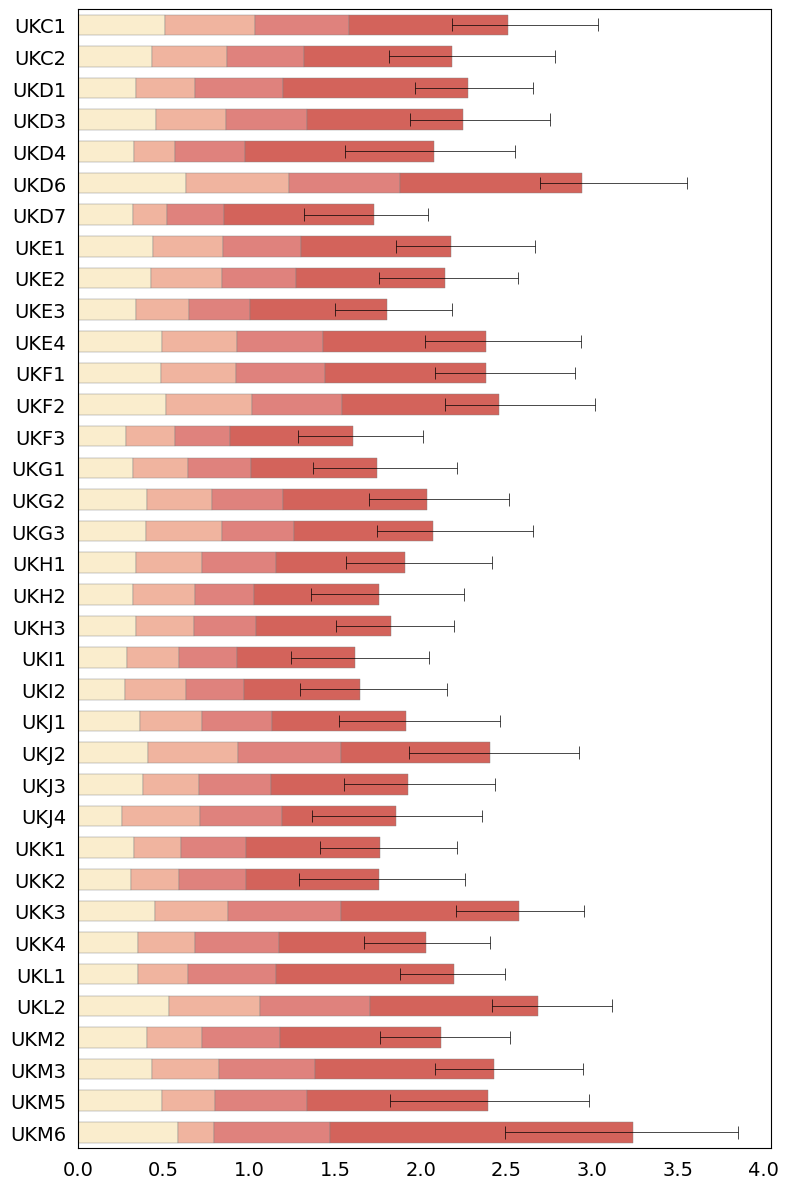

In [ ]:
# # 按列索引的前缀（例如 'UKC1'）进行 groupby 操作，并对每组求和
# # 转置后列名 变成 行索引，然后按行索引的前缀进行分组求和，再转置回来
# IOX_REG_C = IOX_TIM.T.groupby(lambda col: col.split('_')[0]).sum().T #  REG_C为区域总损失
# IOX_SEC_C = IOX_TIM.T.groupby(lambda col: col.split('_')[1]).sum().T #  SEC_C为部门总损失

# IOX_REG_C_0 = IOX_REG_C.iloc[0] # 初始区域GDP
# IOX_SEC_C_0 = IOX_SEC_C.iloc[0] # 初始部门GDP